In [2]:
#Read Data

In [24]:
# Library
import numpy as np
import cv2
import matplotlib.pyplot as plt
cv2.__version__


'4.2.0'

In [134]:
#General Settings
folder = 'video-data/kitti/2011_09_26_drive_0001_extract/image_02/data/'
image = '0000000100.png'

In [135]:
def getImage(): 
    img = cv2.imread(folder + image) # reads image 'opencv-logo.png' as grayscale
    return img

In [136]:
def getGrayImage(): 
    # Convert to Grayscale
    return cv2.cvtColor(getImage(), cv2.COLOR_BGR2GRAY) 

In [159]:
# Reshape Image
def reshapeImage():
    resized_image = cv2.resize(getGrayImage(), (750, 250)) 

In [185]:
def gaussianBlur(image):
    return cv2.GaussianBlur(image,(5,5),0)

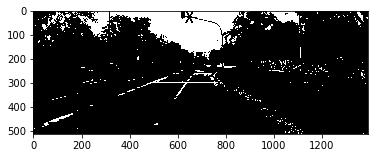

In [169]:
mask_white = cv2.inRange(getGrayImage(), 200, 255)
plt.imshow(mask_white, cmap='gray')


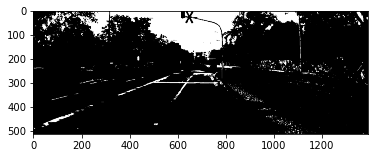

In [186]:
mask_white_gaussian = gaussianBlur(mask_white)
plt.imshow(mask_white_gaussian, cmap='gray')


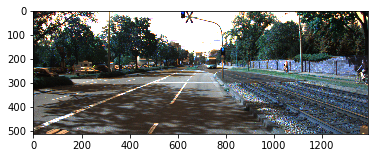

In [168]:
plt.imshow(mask_white_gaussian, cmap='gray')

In [ ]:
kernel_size = 5
gauss_gray = gaussian_blur(mask_yw_image,kernel_size)